This playbook is based on the new implementation codes, main differences are:

1. one cutoff for all cortical vectors, now the sparsity is an averge sparsity over the whole matrix

2. check the normalization of random connection matrix. The previous one is also correct.

In [1]:
from mix_forward import mix_forward
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook
display.set_matplotlib_formats('svg')

### 0. Check the rank calculation

In [121]:
P = 40
K = 5
N = 100
M = 100
Nm = 3
Nc = 900

In [122]:
model_3_test = mix_forward(Nm,N,M,P,K,Nc)

In [123]:
EDM_test = model_3_test.order_m(3,f=0.02,initial_data=True)

In [124]:
EDM_test.shape

(1000, 900)

In [22]:
np.linalg.matrix_rank(EDM_test)

732

In [12]:
(u,s,v) = np.linalg.svd(EDM_test)

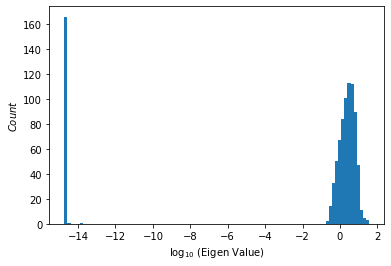

In [19]:
plt.hist(np.log10(s),bins=100)
plt.xlabel('$\log_{10}$ (Eigen Value)')
plt.ylabel('$Count$')
plt.show()

In [21]:
(s > 10**-10).sum()

732

In [20]:
EDM_test2 = model_3_test.order_m(3,f=0.006,initial_data=True)

In [23]:
np.linalg.matrix_rank(EDM_test2)

473

In [24]:
(u2,s2,v2) = np.linalg.svd(EDM_test2)

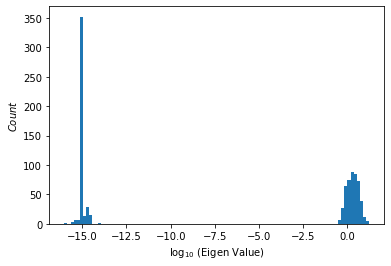

In [25]:
plt.hist(np.log10(s2),bins=100)
plt.xlabel('$\log_{10}$ (Eigen Value)')
plt.ylabel('$Count$')
plt.show()

In [26]:
# S.max() * max(M.shape) * eps

eps =2.2 * 10**(-16)

print(s.max()*max(EDM_test.shape)*eps)
print(s2.max()*max(EDM_test2.shape)*eps)

7.649068566179054e-12
3.573307710643676e-12


### 1. Nc > PK^2, the transition point - Nc relation

In [2]:
P = 40
K = 5
N = 100
M = 100
Nm = 3
Nc_list2 = [2500,2300,2100,1900,1700,1500,1300,1100,1050,800,600]

In [8]:
for Nc in tqdm_notebook(Nc_list2,desc='1st loop'):
    
    locals()['rkNc_'+str(Nc)] = []
    
    if Nc >= 1500: 
        flist = np.linspace(1,20,20)/float(Nc)
        
    elif Nc >= 1200:
        flist = np.linspace(10,60,50)/float(Nc)
        
    else:
        flist = 10**np.linspace(-2.4,-0.3,40)
    
    
    model3_f_Nc = mix_forward(Nm,N,M,P,K,Nc)
    model3_f_Nc.generate_input()

    for f in tqdm_notebook(flist,desc='2nd loop',leave=False):
        
        locals()['rkNc_'+str(Nc)].append(np.linalg.matrix_rank(model3_f_Nc.order_m(3,f)))

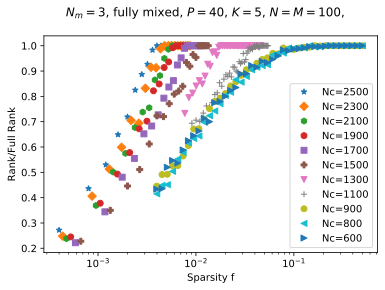

In [10]:
marker = ['*','D','h','o','s','P','v','+','o','<','>']
display.set_matplotlib_formats('svg')
# data collapse with new/correct sparsify method
fig,axs = plt.subplots(1,1)
for i,Nc in enumerate(Nc_list2):
    
    if Nc >= 1500: 
        flist = np.linspace(1,20,20)/float(Nc)
        
    elif Nc >= 1100:
        flist = np.linspace(10,60,50)/float(Nc)
        
    else:
        flist = 10**np.linspace(-2.4,-0.3,40)
    
    axs.plot(flist,np.array(locals()['rkNc_'+str(Nc)])/min(Nc,1000),marker = marker[i],linestyle= 'None',label='Nc={}'.format(Nc))
    
#axs[0].set_xscale('log')
axs.set_xlabel('Sparsity f')
axs.set_ylabel('Rank/Full Rank')
axs.legend()
axs.set_xscale('log')

plt.suptitle(r'$N_m =3$, fully mixed, $P=40$, $K=5$, $N=M=100$,')
plt.show()

In [ ]:
P = 10
K = 10
N = 100
M = 100
Nm = 3
Nc_list2 = [2500,2300,2100,1900,1700,1500,1300,1100]

In [40]:
for Nc in tqdm_notebook(Nc_list2,desc='1st loop'):
    
    locals()['rkNc2_'+str(Nc)] = []
    
    flist = np.linspace(1,50,50)/float(Nc)
    model3_f_Nc = mix_forward(Nm,N,M,P,K,Nc)
    model3_f_Nc.generate_input()

    for f in tqdm_notebook(flist,desc='2nd loop',leave=False):
        
        locals()['rkNc2_'+str(Nc)].append(np.linalg.matrix_rank(model3_f_Nc.order_m(3,f)))

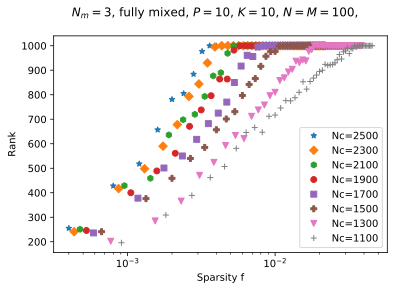

In [41]:
marker = ['*','D','h','o','s','P','v','+']
display.set_matplotlib_formats('svg')
# data collapse with new/correct sparsify method
fig,axs = plt.subplots(1,1)
for i,Nc in enumerate(Nc_list2):
    axs.plot(np.linspace(1,50,50)/Nc,locals()['rkNc2_'+str(Nc)],marker = marker[i],linestyle= 'None',label='Nc={}'.format(Nc))
    
#axs[0].set_xscale('log')
axs.set_xlabel('Sparsity f')
axs.set_ylabel('Rank')
axs.legend()
axs.set_xscale('log')

plt.suptitle(r'$N_m =3$, fully mixed, $P=10$, $K=10$, $N=M=100$,')
plt.show()

In [2]:
def find_turning_point(a,plateau_Value=None):
    
    if plateau_Value == None:
        plateau_Value = max(a)
        
    w = np.argwhere(np.array(a) < plateau_Value)
    
    return w[-1,0]

In [100]:
find_turning_point(rkNc_2500)

8

In [67]:
# P = 40, K = 5
res1 = np.zeros((2,8))
for i,Nc in enumerate(Nc_list2):
    res1[0,i] = Nc
    turning_index = find_turning_point(locals()['rkNc_'+str(Nc)],plateau_Value=1000)
    res1[1,i] = turning_index/Nc

# P = 10, K = 10
res2 = np.zeros((2,8))
for i,Nc in enumerate(Nc_list2):
    res2[0,i] = Nc
    turning_index = find_turning_point(locals()['rkNc2_'+str(Nc)],plateau_Value=1000)
    res2[1,i] = turning_index/Nc

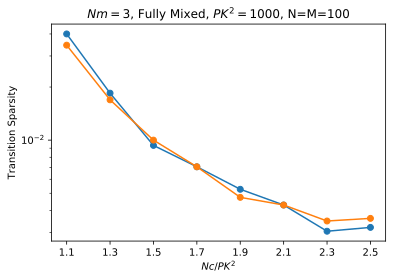

In [82]:
plt.plot(res1[0,:]/1000,res1[1,:],'o-')
plt.plot(res2[0,:]/1000,res2[1,:],'o-')
plt.xlabel(r'$Nc/PK^2$')
plt.xticks([2.5,2.3,2.1,1.9,1.7,1.5,1.3,1.1])
plt.ylabel('Transition Sparsity')
plt.title(r'$Nm = 3$, Fully Mixed, $PK^2 = 1000$, N=M=100')
#ax = plt.gca()
#ax.get_xaxis().get_major_formatter().set_useOffset(False)
#plt.xscale('log')
plt.yscale('log')
plt.show()

### 1.1 Generalize Transition point and Nc relation

In [126]:
P = 40
K = 5
N = 100
M = 100
Nm = 3
Nc_list3= np.round(1000*np.concatenate((np.arange(0.3,1.0,0.05),np.arange(1.0,1.5,0.03),np.arange(1.5,3.0,0.1))))

In [110]:
res3 = np.zeros((2,Nc_list3.shape[0]))
i = 0

for Nc in tqdm_notebook(Nc_list3,desc='1st loop'):
    
    locals()['rkNc3_'+str(int(Nc))] = []
    
    if Nc >= 1500: 
        flist = np.linspace(1,20,20)/float(Nc)
    elif Nc >= 1100:
        flist = np.linspace(10,60,50)/float(Nc)
    else:
        flist = 10**np.linspace(-1.5,-0.3,40)
    
    model3_f_Nc = mix_forward(Nm,N,M,P,K,Nc)
    model3_f_Nc.generate_input()

    for f in flist:
        
        locals()['rkNc3_'+str(Nc)].append(np.linalg.matrix_rank(model3_f_Nc.order_m(3,f)))
    
    res3[0,i] = Nc
    turning_index = find_turning_point(locals()['rkNc3_'+str(int(Nc))],plateau_Value=min(Nc,1000))
    res3[1,i] = flist[turning_index] 
    
    i = i + 1

In [25]:
P = 40
K = 5
N = 100
M = 100
Nm = 3
Nc_list4= np.round(1000*np.concatenate((np.arange(0.3,1.0,0.02),1+10**np.arange(-3,-0.7,0.2),np.arange(1.2,3.0,0.15))))

In [27]:
Nc_list4

array([ 300.,  320.,  340.,  360.,  380.,  400.,  420.,  440.,  460.,
        480.,  500.,  520.,  540.,  560.,  580.,  600.,  620.,  640.,
        660.,  680.,  700.,  720.,  740.,  760.,  780.,  800.,  820.,
        840.,  860.,  880.,  900.,  920.,  940.,  960.,  980., 1001.,
       1002., 1003., 1004., 1006., 1010., 1016., 1025., 1040., 1063.,
       1100., 1158., 1200., 1350., 1500., 1650., 1800., 1950., 2100.,
       2250., 2400., 2550., 2700., 2850.])

In [9]:
res4 = np.zeros((2,Nc_list4.shape[0]))
i = 0

for Nc in tqdm_notebook(Nc_list4,desc='1st loop'):
    
    locals()['rkNc4_'+str(int(Nc))] = []
    
    if Nc >= 1500: 
        flist = np.linspace(1,20,20)/float(Nc)
    elif Nc >= 1100:
        flist = np.linspace(10,60,50)/float(Nc)
    else:
        flist = 10**np.linspace(-1.5,-0.3,40)
    
    model3_f_Nc = mix_forward(Nm,N,M,P,K,Nc)
    model3_f_Nc.generate_input()

    for f in flist:
        
        locals()['rkNc4_'+str(int(Nc))].append(np.linalg.matrix_rank(model3_f_Nc.order_m(3,f)))
    
    res4[0,i] = Nc
    turning_index = find_turning_point(locals()['rkNc4_'+str(int(Nc))],plateau_Value=min(Nc,1000))
    res4[1,i] = flist[turning_index] 
    
    i = i + 1

In [137]:
w = np.where(res3[0,:] >= 1500)[0]

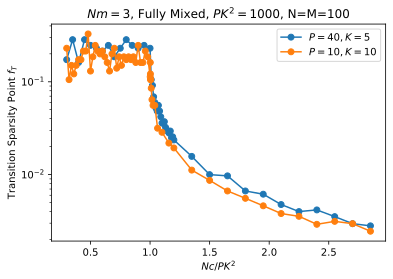

In [31]:
display.set_matplotlib_formats('svg')
plt.plot(res4[0,:]/1000,res4[1,:],'o-',label=r'$P=40, K=5$')
plt.plot(res42[0,:]/1000,res42[1,:],'o-',label=r'$P=10, K=10$')
plt.xlabel(r'$Nc/PK^2$')
plt.ylabel(r'Transition Sparsity Point $f_T$')
plt.title(r'$Nm = 3$, Fully Mixed, $PK^2 = 1000$, N=M=100')
#ax = plt.gca()
#ax.get_xaxis().get_major_formatter().set_useOffset(False)
#plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.show()

In [156]:
np.savetxt(r'Nc_transition_point.txt',np.vstack((res4.T,res3[:,w].T)),fmt='%.5f',header='Nm = 3, Fully Mixed, P=40,K= 5, N=M=100')

In [28]:
P = 10
K = 10
N = 100
M = 100
Nm = 3
Nc_list4= np.round(1000*np.concatenate((np.arange(0.3,1.0,0.02),1+10**np.arange(-3,-0.7,0.2),np.arange(1.2,3.0,0.15))))

In [29]:
res42 = np.zeros((2,Nc_list4.shape[0]))
i = 0

for Nc in tqdm_notebook(Nc_list4,desc='1st loop'):
    
    locals()['rkNc42_'+str(int(Nc))] = []
    
    if Nc >= 1500: 
        flist = np.linspace(1,20,20)/float(Nc)
    elif Nc >= 1100:
        flist = np.linspace(10,60,50)/float(Nc)
    else:
        flist = 10**np.linspace(-1.5,-0.3,40)
    
    model3_f_Nc = mix_forward(Nm,N,M,P,K,Nc)
    model3_f_Nc.generate_input()

    for f in flist:
        
        locals()['rkNc42_'+str(int(Nc))].append(np.linalg.matrix_rank(model3_f_Nc.order_m(3,f)))
    
    res42[0,i] = Nc
    turning_index = find_turning_point(locals()['rkNc42_'+str(int(Nc))],plateau_Value=min(Nc,1000))
    res42[1,i] = flist[turning_index] 
    
    i = i + 1

In [32]:
np.savetxt(r'Nc_transition_point.txt',res4,fmt='%.5f',header='# Nm = 3, Fully Mixed, P=40, K=5, N=M=100')
np.savetxt(r'Nc_transition_point2.txt',res42,fmt='%.5f',header='# Nm = 3, Fully Mixed, P=10, K=10, N=M=100')

### 2. Covariance Matrix

In [2]:
P = 40
K = 5
N = 100
M = 100
Nm = 3
Nc = 1100

In [3]:
model_3_cm = mix_forward(Nm,N,M,P,K,Nc)

In [4]:
EDM,h = model_3_cm.order_m(3,f=0.01,initial_data=True,return_h=True)

In [5]:
C_h = np.matmul(h,h.T)

In [7]:
C_h_flat = C_h.flatten()

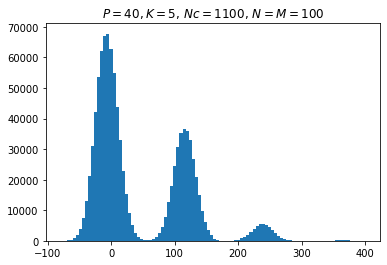

In [14]:
plt.hist(C_h_flat,bins=100)
plt.title(r'$P = 40, K = 5$, $Nc = 1100$, $N=M=100$')
plt.show()

In [9]:
C_m = np.matmul(EDM,EDM.T)

In [13]:
np.linalg.matrix_rank(EDM)

719

In [10]:
C_m_flat = C_m.flatten()

In [12]:
C_m_flat.max()

23.0

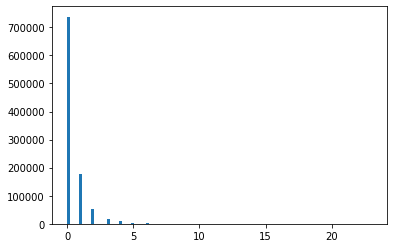

In [11]:
plt.hist(C_m_flat,bins=100)
plt.show()

In [15]:
P = 40
K = 5
N = 100
M = 100
Nm = 3
Nc = 2000
model_3_cm = mix_forward(Nm,N,M,P,K,Nc)
EDM,h = model_3_cm.order_m(3,f=0.01,initial_data=True,return_h=True)

In [16]:
C_h = np.matmul(h,h.T)
C_h_flat = C_h.flatten()

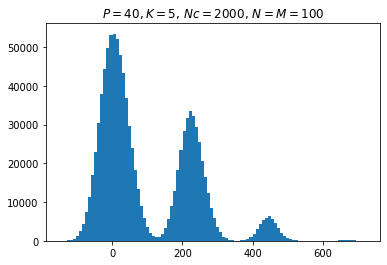

In [17]:
plt.hist(C_h_flat,bins=100)
plt.title(r'$P = 40, K = 5$, $Nc = 2000$, $N=M=100$')
plt.show()

AttributeError: 'list' object has no attribute 'shape'